<a href="https://colab.research.google.com/github/Jojo666/Coursera_Capstone/blob/main/Singapore_thai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IBM Capstone Project**

In this project, I will find out the best neighborhood in Singapore for  to open a new Thai Restaurant by:

1.   Using multiple datasets from different sources (i.e. Web, Geocode, CSV files, Foursquare API)
2.   Python Webscraping using Beautifulsoup
3.   Data Preprocessing
4.   Data Analysis

I will obtain the geolocations of the different Planning Areas located within 5 of Singapore's Regions (North, West, Central) and use the Foursquare API to extract the details of venues near the planning areas. My gaols is to look for planning areas with the lowest clustering of Thai resturants (using unsupervised learning) as these planning areas will have the lowest competition for a new Thai resturant

Target audience: (a) Those looking to set up a Thai resturant in Singapore (b) People intersted in the resturant business in Sinagpore (c) People intersted in the different social enues in the different parts of Singapore

In [ ]:
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from lxml.html import fromstring 
import re
import csv
import pandas as pd



**Step 1:**
I scraped wikipedia for the list of places in Singapore. I looped through multiple pages to obtain details of the 5 Regions and their associated Planning Areas within Singapore 

In [ ]:
wiki = "https://en.wikipedia.org/wiki/List_of_places_in_Singapore"
header = {'User-Agent': 'Mozilla/5.0'}
req = Request(wiki,headers=header)
page = urlopen(req)

soup = BeautifulSoup(page, features="lxml")


def get_remaining_tables():
    global df
    planning_area = []
    subzone = []
    region =[]
    footnotes = []

    ul_ids = {'East': 1, 'North': 7, 'North-East': 14, 'West': 21}
    unorderedLists = soup.find_all('ul')

    for x in ul_ids:
        eastern_region1 = unorderedLists[ul_ids[x]].findChild('li')
        eastern_regions = eastern_region1.find_next_siblings('li')
        eastern_regions.insert(0,eastern_region1)
        for i in eastern_regions:
            kids = i.findChildren('li')
            for j in kids:    
                
                try:
                        if j.find_parent('li').find_previous_sibling('li').findChild('li'):
                            pass
                        else:
                            if j.find_parent('li').find_previous_sibling('li').findChild('a').text not in planning_area:
                                planning_area.append(j.find_parent('li').find_previous_sibling('li').findChild('a').text)
                                subzone.append(j.find_parent('li').find_previous_sibling('li').findChild('a').text)
                                region.append(x)
                                footnotes.append('')
              
                        if j.find_parent('li').find_previous_sibling('li').find_previous_sibling('li').findChild('li'):
                            pass
                        else:
                            if j.find_parent('li').find_previous_sibling('li').find_previous_sibling('li').findChild('a').text not in planning_area:
                                planning_area.append(j.find_parent('li').find_previous_sibling('li').find_previous_sibling('li').findChild('a').text)
                                subzone.append(j.find_parent('li').find_previous_sibling('li').find_previous_sibling('li').findChild('a').text)
                                region.append(x)
                                footnotes.append('')
                except:
                      pass
                planning_area.append(j.find_parent('li').find('a').text)
                subzone_string = str(j.text)
                try:
                    if subzone_string.index('('):
                        parsed_subzone = subzone_string.index('(')
                        footnotes.append(subzone_string[int(parsed_subzone):])
                        subzone.append(subzone_string[:int(parsed_subzone)])
                       
                except:
                    footnotes.append('')
                    subzone.append(subzone_string)
                region.append(x)

    planning_area.append('Western Water Catchment')
    subzone.append('Western Water Catchment')
    region.append('West')
    footnotes.append('')
    
    df = pd.DataFrame(list(zip(region, planning_area, subzone, footnotes)), columns = list(['Region', 'Planning Area', 'Subzone', 'Footnotes']))



def get_central_table():
    global df2
    master_list = []
    header_list = []
    table = soup.find_all('table')[1]
    headers = table.find_all('th')
    for header in headers:
        header_list.append(header.text)
    rows = table.find_all('tr')
    for row in rows[1:]:
        row_data = []
        row_length = len(row.find_all('td'))
        if row_length ==2:
            planning_area = False
        elif row_length ==3:
            planning_area = True
        if planning_area:
           planning_area_raw = row.findChild('td').text.strip()
           index_bracket = planning_area_raw.index('[')
           planning_area_text = planning_area_raw[:int(index_bracket)]
           subzone_text = row.findChild('td').find_next_sibling('td').text.strip()
           footnote_text = row.findChild('td').find_next_sibling('td').find_next_sibling('td').text.strip()
           row_data.append(planning_area_text)
           row_data.append(subzone_text)
           row_data.append(footnote_text)
           master_list.append(row_data)
        else:
           planning_area_text = ''
           subzone_text = row.findChild('td').text.strip()
           try:
                footnote_text = row.findChild('td').find_next_sibling('td').text.strip()
           except:
                footnote_text = ''
           row_data.append(planning_area_text)
           row_data.append(subzone_text)
           row_data.append(footnote_text)
           master_list.append(row_data)
    for a in range(len(master_list)):
        if master_list[a][0] == '':
            master_list[a][0] = master_list[a-1][0]
    for b in range(len(master_list)):
        master_list[b].insert(0,'Central')
    df2 = pd.DataFrame(data = master_list, columns = list(['Region', 'Planning Area', 'Subzone', 'Footnotes']))
    


    


get_central_table()
get_remaining_tables()

df3 = df2.append(df, ignore_index=True)
#df3.to_excel('Test.xlsx', index=False)
df3.to_pickle('Subzone Dataframe.pkl')

# Parse List for Dataframe of Planning Areas
df4 = df3
df4.drop_duplicates(subset ='Planning Area', keep="first", inplace=True, ignore_index=True)
df4.drop('Subzone', axis=1, inplace=True)
df4.drop('Footnotes', axis=1, inplace=True)
df4.to_pickle('Planning Area Dataframe.pkl')

In [ ]:
df3

Region            Planning Area
0      Central                   Bishan
1      Central              Bukit Merah
2      Central              Bukit Timah
3      Central            Downtown Core
4      Central                  Geylang
5      Central                  Kallang
6      Central              Marina East
7      Central             Marina South
8      Central            Marine Parade
9      Central                   Museum
10     Central                   Newton
11     Central                   Novena
12     Central                  Orchard
13     Central                   Outram
14     Central               Queenstown
15     Central             River Valley
16     Central                   Rochor
17     Central          Singapore River
18     Central         Southern Islands
19     Central             Straits View
20     Central                  Tanglin
21     Central                Toa Payoh
22        East                    Bedok
23        East                   Changi
24        East               Changi Bay
25        East                Pasir Ris
26        East               Paya Lebar
27        East                 Tampines
28       North             Lim Chu Kang
29       North  Central Water Catchment
30       North                   Mandai
31       North                Sembawang
32       North                  Simpang
33       North             Sungei Kadut
34       North                Woodlands
35       North                   Yishun
36  North-East               Ang Mo Kio
37  North-East                  Hougang
38  North-East    North-Eastern Islands
39  North-East                  Punggol
40  North-East                  Seletar
41  North-East                 Sengkang
42  North-East                Serangoon
43        West                 Boon Lay
44        West              Bukit Batok
45        West            Bukit Panjang
46        West            Choa Chu Kang
47        West                 Clementi
48        West              Jurong East
49        West              Jurong West
50        West                  Pioneer
51        West                   Tengah
52        West                     Tuas
53        West          Western Islands
54        West  Western Water Catchment

In [ ]:
dfx = df3.rename({'Planning Area': 'Area'}, axis=1) 

In [ ]:
dfx.head()

Region           Area
0  Central         Bishan
1  Central    Bukit Merah
2  Central    Bukit Timah
3  Central  Downtown Core
4  Central        Geylang

**Step 2**
Geocoding Singapore's Planning Areas using geopy

In [ ]:
!pip install geopandas
!pip install geopy

     |████████████████████████████████| 1.0MB 6.2MB/s 
     |████████████████████████████████| 15.3MB 272kB/s 
     |████████████████████████████████| 6.5MB 39.9MB/s 


In [ ]:
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and lo

In [ ]:
locator = Nominatim(user_agent='myGeocoder')


In [ ]:
from geopy.extra.rate_limiter import RateLimiter

# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# 2- - create location column
dfx['location'] = dfx['Area'].apply(geocode)
# 3 - create longitude, laatitude and altitude from location column (returns tuple)
dfx['point'] = dfx['location'].apply(lambda loc: tuple(loc.point) if loc else None)
# 4 - split point column into latitude, longitude and altitude columns
dfx[['latitude', 'longitude', 'altitude']] = pd.DataFrame(dfx['point'].tolist(), index=dfx.index)

In [ ]:
dfx.head()

Region           Area  ...   longitude altitude
0  Central         Bishan  ...  103.848255      0.0
1  Central    Bukit Merah  ...  100.764092      0.0
2  Central    Bukit Timah  ...  103.776372      0.0
3  Central  Downtown Core  ...  103.856033      0.0
4  Central        Geylang  ...  103.887056      0.0

[5 rows x 7 columns]

In [ ]:
dfx.drop(['location', 'point','altitude'], axis='columns', inplace=True)

In [ ]:
dfx.head(n=6)

Region           Area  latitude   longitude
0  Central         Bishan  1.350986  103.848255
1  Central    Bukit Merah  6.210210  100.764092
2  Central    Bukit Timah  1.354690  103.776372
3  Central  Downtown Core  1.287475  103.856033
4  Central        Geylang  1.318186  103.887056
5  Central        Kallang  1.310759  103.866262

'dfx' dataframe contains the details of Singapore's Regions, Planning Areas and the latitudes and longitudes of the latter

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
#dfx.to_csv('/content/drive/MyDrive/IBM/singapore_geo1.csv')

In [ ]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation


!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


! pip install folium==0.5.0
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

     |████████████████████████████████| 81kB 4.9MB/s 
  Created wheel for folium: filename=folium-0.5.0-cp37-none-any.whl size=76240 sha256=ad50ea084467cb981a843dbfd803b4fa849b8ec7329db881c56b80b4e6af6fb2
  Stored in directory: /root/.cache/pip/wheels/f8/98/ff/954791afc47740d554f0d9e5885fa09dd60c2265d42578e665
Successfully built folium
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.5.0 which is incompatible.
  Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
Folium installed
Libraries imported.


**Step 3**
Obtain the data of different ventues from Foursquare's API

In [ ]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [ ]:
## Singapore's lat-longs and venues

In [ ]:
address = 'Singapore'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

1.357107 103.8194992


Obtain venues corresponding to the lat-long locations from the Foursquare API

We will obtain the following infomration about the Venues: (a) Venue lat long (b) venue category (c) venue name

In [ ]:
radius = 5000
LIMIT = 100

def getVenues(names, latitudes, longitudes, radius=5000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue_Lat', 
                  'Venue_Long', 
                  'Venue_Category']
    
    return(nearby_venues)

In [ ]:
dfx.head()

Region           Area  latitude   longitude
0  Central         Bishan  1.350986  103.848255
1  Central    Bukit Merah  6.210210  100.764092
2  Central    Bukit Timah  1.354690  103.776372
3  Central  Downtown Core  1.287475  103.856033
4  Central        Geylang  1.318186  103.887056

Obtain Singapore's venues for the different Planning Areas via getVenues 

In [ ]:
Singapore_Venues = getVenues(names=dfx['Area'],
                        latitudes=dfx['latitude'],
                        longitudes=dfx['longitude'])


Bishan
Bukit Merah
Bukit Timah
Downtown Core
Geylang
Kallang
Marina East
Marina South
Marine Parade
Museum
Newton
Novena
Orchard
Outram
Queenstown
River Valley
Rochor
Singapore River
Southern Islands
Straits View
Tanglin
Toa Payoh
Bedok
Changi
Changi Bay
Pasir Ris
Paya Lebar
Tampines
Lim Chu Kang
Central Water Catchment
Mandai
Sembawang
Simpang
Sungei Kadut
Woodlands
Yishun
Ang Mo Kio
Hougang
North-Eastern Islands
Punggol
Seletar
Sengkang
Serangoon
Boon Lay
Bukit Batok
Bukit Panjang
Choa Chu Kang
Clementi
Jurong East
Jurong West
Pioneer
Tengah
Tuas
Western Islands
Western Water Catchment


The different venues by their geolocations, names and categories

In [ ]:
Singapore_Venues.head()

Borough  Latitude   Longitude  ... Venue_Lat  Venue_Long       Venue_Category
0  Bishan  1.350986  103.848255  ...  1.362219  103.846250                 Park
1  Bishan  1.350986  103.848255  ...  1.362292  103.847602                  Spa
2  Bishan  1.350986  103.848255  ...  1.350549  103.848659  Japanese Restaurant
3  Bishan  1.350986  103.848255  ...  1.355269  103.836719    Indian Restaurant
4  Bishan  1.350986  103.848255  ...  1.351867  103.837558               Bakery

[5 rows x 7 columns]

In [ ]:
Singapore_Venues.groupby('Borough').count()

Latitude  Longitude  ...  Venue_Long  Venue_Category
Borough                                       ...                            
Ang Mo Kio                    100        100  ...         100             100
Bedok                         100        100  ...         100             100
Bishan                        100        100  ...         100             100
Boon Lay                      100        100  ...         100             100
Bukit Batok                   100        100  ...         100             100
Bukit Merah                     2          2  ...           2               2
Bukit Panjang                 100        100  ...         100             100
Bukit Timah                   100        100  ...         100             100
Central Water Catchment       100        100  ...         100             100
Changi                          2          2  ...           2               2
Changi Bay                     35         35  ...          35              35
Choa Chu Kang                 100        100  ...         100             100
Clementi                      100        100  ...         100             100
Downtown Core                 100        100  ...         100             100
Geylang                       100        100  ...         100             100
Hougang                       100        100  ...         100             100
Jurong East                   100        100  ...         100             100
Jurong West                   100        100  ...         100             100
Kallang                       100        100  ...         100             100
Lim Chu Kang                   55         55  ...          55              55
Mandai                          2          2  ...           2               2
Marina East                   100        100  ...         100             100
Marina South                  100        100  ...         100             100
Marine Parade                 100        100  ...         100             100
Museum                          5          5  ...           5               5
Newton                          4          4  ...           4               4
North-Eastern Islands           9          9  ...           9               9
Novena                        100        100  ...         100             100
Orchard                         5          5  ...           5               5
Outram                        100        100  ...         100             100
Pasir Ris                     100        100  ...         100             100
Paya Lebar                    100        100  ...         100             100
Punggol                       100        100  ...         100             100
Queenstown                     66         66  ...          66              66
River Valley                   19         19  ...          19              19
Rochor                        100        100  ...         100             100
Seletar                       100        100  ...         100             100
Sembawang                     100        100  ...         100             100
Sengkang                      100        100  ...         100             100
Serangoon                     100        100  ...         100             100
Simpang                         4          4  ...           4               4
Singapore River               100        100  ...         100             100
Southern Islands               10         10  ...          10              10
Straits View                  100        100  ...         100             100
Sungei Kadut                  100        100  ...         100             100
Tampines                      100        100  ...         100             100
Tanglin                       100        100  ...         100             100
Tengah                          1          1  ...           1               1
Toa Payoh                     100        100  ...         100             100
Tuas                          100        100  .

How many unique venues are there

In [ ]:
print('There are {} uniques categories.'.format(len(Singapore_Venues['Venue_Category'].unique())))

There are 289 uniques categories.


In [ ]:
Singapore_Venues_unique_count = Singapore_Venues['Venue_Category'].value_counts().to_frame(name='Count')

Some of the most common social venues in Singapore

In [ ]:
Singapore_Venues_unique_count

Count
Hotel                        199
Chinese Restaurant           183
Coffee Shop                  171
Park                         147
Café                         136
...                          ...
Gaming Cafe                    1
Middle Eastern Restaurant      1
Hockey Field                   1
Hobby Shop                     1
Military Base                  1

[289 rows x 1 columns]

In [ ]:
# one hot encoding
singapore_onehot = pd.get_dummies(Singapore_Venues[['Venue_Category']], prefix = "", prefix_sep = "")

In [ ]:
singapore_onehot.head()

Accessories Store  Airport  ...  Zoo  Zoo Exhibit
0                  0        0  ...    0            0
1                  0        0  ...    0            0
2                  0        0  ...    0            0
3                  0        0  ...    0            0
4                  0        0  ...    0            0

[5 rows x 289 columns]

In [ ]:
# add neighborhood column back to dataframe
singapore_onehot['Borough'] = Singapore_Venues['Borough']

In [ ]:
# move neighborhood column to the first column
fixed_columns = [singapore_onehot.columns[-1]] + list(singapore_onehot.columns[:-1])
singapore_onehot = singapore_onehot[fixed_columns]

In [ ]:
singapore_onehot.head()

Borough  Accessories Store  Airport  ...  Yunnan Restaurant  Zoo  Zoo Exhibit
0  Bishan                  0        0  ...                  0    0            0
1  Bishan                  0        0  ...                  0    0            0
2  Bishan                  0        0  ...                  0    0            0
3  Bishan                  0        0  ...                  0    0            0
4  Bishan                  0        0  ...                  0    0            0

[5 rows x 290 columns]

Check for Thai resturant

In [ ]:
singapore_onehot.loc[singapore_onehot['Thai Restaurant'] != 0]

Borough  Accessories Store  ...  Zoo  Zoo Exhibit
5          Bishan                  0  ...    0            0
29         Bishan                  0  ...    0            0
53         Bishan                  0  ...    0            0
143   Bukit Timah                  0  ...    0            0
185   Bukit Timah                  0  ...    0            0
...           ...                ...  ...  ...          ...
3630     Clementi                  0  ...    0            0
3807  Jurong East                  0  ...    0            0
3863  Jurong West                  0  ...    0            0
3943         Tuas                  0  ...    0            0
3946         Tuas                  0  ...    0            0

[67 rows x 290 columns]

In [ ]:
se_grouped = singapore_onehot.groupby('Borough').mean().reset_index()

In [ ]:
se_grouped.head()

Borough  Accessories Store  ...   Zoo  Zoo Exhibit
0   Ang Mo Kio               0.00  ...  0.00         0.00
1        Bedok               0.00  ...  0.00         0.00
2       Bishan               0.00  ...  0.00         0.00
3     Boon Lay               0.01  ...  0.01         0.02
4  Bukit Batok               0.01  ...  0.00         0.00

[5 rows x 290 columns]

In [ ]:
thai = se_grouped[["Borough","Thai Restaurant"]]
thai.head() #.head() shows the first five rows only

Borough  Thai Restaurant
0   Ang Mo Kio             0.06
1        Bedok             0.03
2       Bishan             0.03
3     Boon Lay             0.01
4  Bukit Batok             0.02

**Step 4**
Now we will cluster the neighborhoods using k-means

In [ ]:
kclusters = 4

thais_grouped_clustering = thai.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 0, 0, 3, 0, 1, 3, 0, 2, 1], dtype=int32)

In [ ]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = thai.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [ ]:
to_merged.head()

Borough  Thai Restaurant  Cluster Labels
0   Ang Mo Kio             0.06               2
1        Bedok             0.03               0
2       Bishan             0.03               0
3     Boon Lay             0.01               3
4  Bukit Batok             0.02               0

In [ ]:
# merge add latitude/longitude for each neighborhood
to_merged = to_merged.join(Singapore_Venues.set_index("Borough"), on="Borough")

print(to_merged.shape)
to_merged.head()

(4066, 9)


Borough  Thai Restaurant  ...  Venue_Long  Venue_Category
0  Ang Mo Kio             0.06  ...  103.846250            Park
0  Ang Mo Kio             0.06  ...  103.847602             Spa
0  Ang Mo Kio             0.06  ...  103.853186       BBQ Joint
0  Ang Mo Kio             0.06  ...  103.848389     Snack Place
0  Ang Mo Kio             0.06  ...  103.848886     Supermarket

[5 rows x 9 columns]

In [ ]:
to_merged['Venue_Category'].value_counts()['Thai Restaurant']

67

Visualise the data 

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Latitude'], to_merged['Longitude'], to_merged['Borough'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

In [ ]:
thai["Cluster Labels"] = kmeans.labels_
thai.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Borough  Thai Restaurant  Cluster Labels
0   Ang Mo Kio             0.06               2
1        Bedok             0.03               0
2       Bishan             0.03               0
3     Boon Lay             0.01               3
4  Bukit Batok             0.02               0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

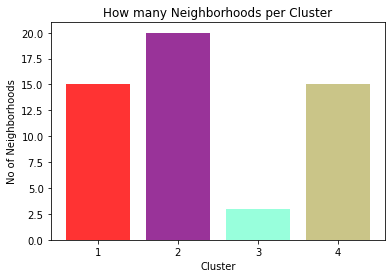

In [ ]:
objects = (1,2,3,4)

y_pos = np.arange(len(objects))
performance = thai['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()


In [ ]:
thai['Cluster Labels'].value_counts()

1    20
3    15
0    15
2     3
Name: Cluster Labels, dtype: int64

**My Recommendation For Opening a New Thai Resturant in Singapore **

While cluster 1 has the maximum number of resturants, cluster 0 and cluster 3 have 15 each. Cluster 2 has the lowest number of resturants. So areas such as Holland park which have the lowest number of Thai resturants can be considered as  vaiable area for opening a Thai resturant owing to lower competition. Planning areas such as Changi and Serangoon road which have a high concentration of Thai resturants can have a higher competition for a newer Thai estabilishment

In [ ]:
dfx.head()

Region           Area  latitude   longitude
0  Central         Bishan  1.350986  103.848255
1  Central    Bukit Merah  6.210210  100.764092
2  Central    Bukit Timah  1.354690  103.776372
3  Central  Downtown Core  1.287475  103.856033
4  Central        Geylang  1.318186  103.887056

In [ ]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = dfx.copy()
df_new.head()

Region           Area  latitude   longitude
0  Central         Bishan  1.350986  103.848255
1  Central    Bukit Merah  6.210210  100.764092
2  Central    Bukit Timah  1.354690  103.776372
3  Central  Downtown Core  1.287475  103.856033
4  Central        Geylang  1.318186  103.887056

cluster (in red)

In [ ]:
cluster1.head()

Borough  Thai Restaurant  ...  Venue_Long      Venue_Category
1   Bedok             0.03  ...  103.932514              Bakery
1   Bedok             0.03  ...  103.935235                Café
1   Bedok             0.03  ...  103.934965     Thai Restaurant
1   Bedok             0.03  ...  103.930250  Chinese Restaurant
1   Bedok             0.03  ...  103.930520      Breakfast Spot

[5 rows x 9 columns]

In [ ]:
df_cluster1=(df_new.assign(dummy=1)
    .merge(cluster1.assign(dummy=1),on='dummy')
    .query('abs(latitude-Latitude)<=0.1 and abs(longitude-Longitude)<=0.2')
    .drop('dummy', axis=1)
)

In [ ]:
df_cluster1.head()

Region    Area  latitude  ...  Venue_Lat  Venue_Long      Venue_Category
0  Central  Bishan  1.350986  ...   1.324691  103.932514              Bakery
1  Central  Bishan  1.350986  ...   1.328047  103.935235                Café
2  Central  Bishan  1.350986  ...   1.328398  103.934965     Thai Restaurant
3  Central  Bishan  1.350986  ...   1.324903  103.930250  Chinese Restaurant
4  Central  Bishan  1.350986  ...   1.324836  103.930520      Breakfast Spot

[5 rows x 13 columns]

cluster 2(purple)

In [ ]:
# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2=(df_new.assign(dummy=1)
    .merge(cluster1.assign(dummy=1),on='dummy')
    .query('abs(latitude-Latitude)<=0.1 and abs(longitude-Longitude)<=0.2')
    .drop('dummy', axis=1)
)

cluster (blue)

In [ ]:
# Blue
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]


In [ ]:
df_cluster3=(df_new.assign(dummy=1)
    .merge(cluster1.assign(dummy=1),on='dummy')
    .query('abs(latitude-Latitude)<=0.1 and abs(longitude-Longitude)<=0.2')
    .drop('dummy', axis=1)
)

cluster 4

In [ ]:
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4=(df_new.assign(dummy=1)
    .merge(cluster1.assign(dummy=1),on='dummy')
    .query('abs(latitude-Latitude)<=0.1 and abs(longitude-Longitude)<=0.2')
    .drop('dummy', axis=1)
)

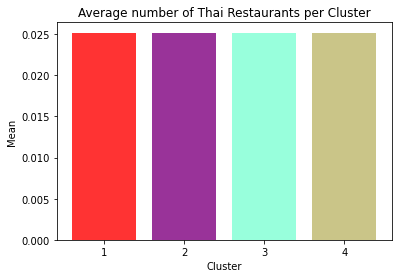

In [ ]:
clusters_mean = [df_cluster1['Thai Restaurant'].mean(),df_cluster2['Thai Restaurant'].mean(),df_cluster3['Thai Restaurant'].mean(),
                 df_cluster4['Thai Restaurant'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Thai Restaurants per Cluster')

plt.show()